In [1]:
import pandas as pd
import numpy as np

## Data Prep

In [2]:
# Load data from file
df = pd.read_csv('../HW3_Data.txt', delimiter='\t')

# Clean up column names, make heatmiser_id into index
df.columns = [x.lower().replace(' ', '_') for x in df.columns]
# df = df.set_index('heatmiser_id')

# Fix duo-naming of 'NonCompliant' / 'Non-Compliant'
df['osha'] = df['osha'].str.replace('-', '')

# Convert 'location_type' into OneHot encoding
df = pd.get_dummies(df, prefix='loc', columns=['location_type'])

df.head()

,heatmiser_id,distance_feature,speeding_feature,osha,loc_Office,loc_Warehouse
0,2018_01,53.76,9,Safe,1,0
1,2018_02,51.86,4,Safe,1,0
2,2018_03,51.59,4,Safe,1,0
3,2018_04,168.90,5,Safe,0,1
4,2018_05,53.50,5,Safe,1,0


## Scikit Learn

### Some Notes

- Uses the "CART" algorithm, rathern than the "ID3" algorithm more like what discussed in class

- Sklearn expects continuous vars, and does not perform explicit binning. Rather, from any given node, each remaining feature is considered, and "every adjacent pair f[i], f[j] of feature values is considered... The best split, according to the Gini/entropy/other split criterion is used to split the dataset". [More info.](https://stackoverflow.com/questions/25287466/binning-of-continuous-variables-in-sklearn-ensemble-and-trees)


- Sklearn does not allow for categorical independent, variable, so location has to encoded using "OneHot" encoding. [More info.](https://datascience.stackexchange.com/questions/5226/strings-as-features-in-decision-tree-random-forest)




### Basic Usage

In [3]:
from sklearn import tree

In [4]:
def seperate_features(df):
    X = df[['distance_feature', 'speeding_feature', 'loc_Office', 'loc_Warehouse']]
    y = df['osha']
    return X, y

In [5]:
X, y = seperate_features(df)
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X, y)

In [6]:
df.loc[12:14]

,heatmiser_id,distance_feature,speeding_feature,osha,loc_Office,loc_Warehouse
12,2018_13,185.39,20,Safe,0,1
13,2018_14,35.87,35,Compliant,1,0
14,2018_15,49.64,5,Safe,1,0


In [7]:
clf.predict(X.loc[12:14])

array(['Safe', 'Compliant', 'Safe'], dtype=object)

### Cross Validation

#### Using Built in tool

In [8]:
from sklearn.model_selection import cross_val_score

X, Y = seperate_features(df)
clf = tree.DecisionTreeClassifier()
cross_val_score(clf, X, Y, cv=10)

array([0.9925187 , 0.99501247, 0.98753117, 0.96259352, 0.98503741,
       0.99002494, 0.9925    , 0.96482412, 0.95226131, 0.98994975])

#### "By Hand"

See: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score

In [9]:
from sklearn.metrics import (accuracy_score, f1_score, precision_score)

In [10]:
def make_model(X, y):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, y)
    return clf

In [11]:
def evaluate_model(y_true, y_pred, stats):
    stats['accuracy'].append(accuracy_score(y_true, y_pred))
    stats['precision'].append(precision_score(y_true, y_pred, average="micro"))
    stats['f1'].append(f1_score(y_true, y_pred, average="micro"))
    return stats

In [12]:
def cross_val(df, k=10):
    """k-fold cross validation"""
    
    stats = {'accuracy':[], 'precision':[], 'f1':[]}
    
    # shuffle df
    shuffle_df = df.sample(frac=1)

    # partition into 10 chunks
    dfs = np.array_split(shuffle_df, 10)

    # build and test model with each chunk
    for i in range(10):
        
        dfs_copy = dfs[:]
        test_samples = dfs_copy.pop(i)
        train_samples = pd.concat(dfs_copy)

        X, Y = seperate_features(train_samples)
        X_test, Y_test = seperate_features(test_samples)

        clf = make_model(X, Y)
        stats = evaluate_model(Y_test, clf.predict(X_test), stats)
        
    return stats

In [13]:
stats = cross_val(df, k=10)

In [14]:
stats_df = pd.DataFrame(stats)
stats_df

,accuracy,f1,precision
0,0.9900,0.9900,0.9900
1,0.9825,0.9825,0.9825
2,0.9725,0.9725,0.9725
3,0.9900,0.9900,0.9900
4,0.9850,0.9850,0.9850
5,0.9850,0.9850,0.9850
6,0.9675,0.9675,0.9675
7,0.9875,0.9875,0.9875
8,0.9875,0.9875,0.9875
9,0.9725,0.9725,0.9725


In [15]:
stats_df

,accuracy,f1,precision
0,0.9900,0.9900,0.9900
1,0.9825,0.9825,0.9825
2,0.9725,0.9725,0.9725
3,0.9900,0.9900,0.9900
4,0.9850,0.9850,0.9850
5,0.9850,0.9850,0.9850
6,0.9675,0.9675,0.9675
7,0.9875,0.9875,0.9875
8,0.9875,0.9875,0.9875
9,0.9725,0.9725,0.9725


### Cross Validation, by class

In [16]:
from sklearn.metrics import f1_score

In [17]:
def make_model(X, y):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, y)
    return clf

In [18]:
def shuffle_and_split(df, k=10):
    shuffle_df = df.sample(frac=1)  # shuffle df
    dfs = np.array_split(shuffle_df, k)   # split into 10 chunks
    return dfs

In [19]:
def model_ith_cross(dfs, i=1):
    dfs_copy = dfs[:]
    test_samples = dfs_copy.pop(i)
    train_samples = pd.concat(dfs_copy)
    
    X, y = seperate_features(train_samples)
    X_test, y_test = seperate_features(test_samples)
    
    clf = make_model(X, y)
    y_pred = clf.predict(X_test)
    
    return y_test, y_pred

In [20]:
def get_scores(y_true, y_pred):
    labels = np.unique(y_pred)
    scores = f1_score(y_true, y_pred, labels=labels, average=None)
    score_dict = dict(zip(labels, scores))
    return score_dict

In [21]:
dfs = shuffle_and_split(df, k=10)
y_true, y_pred = model_ith_cross(dfs, 1)
get_scores(y_true, y_pred)

{'Compliant': 0.9315068493150684,
 'NonCompliant': 0.9411764705882353,
 'Safe': 0.9927849927849928}

In [22]:
baseline = np.repeat(y_true.mode(), len(y_true))
get_scores(y_true, baseline)

{'Safe': 0.92904953145917}

#### Plotting

In [23]:
import seaborn as sns
sns.set_style("whitegrid")

In [24]:
dfs = shuffle_and_split(df, k=10)
res = []
base = []

for i in range(10):
    y_true, y_pred = model_ith_cross(dfs, 1)
    res.append(get_scores(y_true, y_pred))
    
    baseline = np.repeat(y_true.mode(), len(y_true))
    base.append(get_scores(y_true, baseline))

In [25]:
data = pd.DataFrame(res)
data.index.name = 'fold'
data = data.reset_index()

In [26]:
data

,fold,Compliant,NonCompliant,Safe
0,0,0.938776,0.823529,0.994012
1,1,0.938776,0.823529,0.994012
2,2,0.938776,0.823529,0.994012
3,3,0.938776,0.823529,0.994012
4,4,0.938776,0.823529,0.994012
5,5,0.938776,0.823529,0.994012
6,6,0.938776,0.823529,0.994012
7,7,0.938776,0.823529,0.994012
8,8,0.938776,0.823529,0.994012
9,9,0.938776,0.823529,0.994012


In [27]:
melted_data = data.melt(
    id_vars='fold',
    value_vars=['Compliant', 'NonCompliant', 'Safe'])

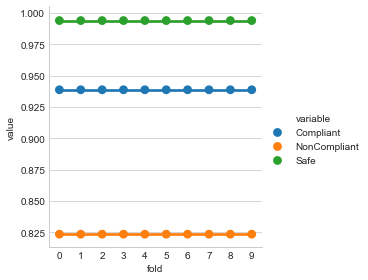

In [28]:
p = sns.factorplot(
    x="fold", y="value",
    hue='variable', data=melted_data)
p.savefig('../images/f1_sklearn_dec_tree.png')

## Display Decision Tree

In [29]:
X, Y = seperate_features(df)
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X, Y)

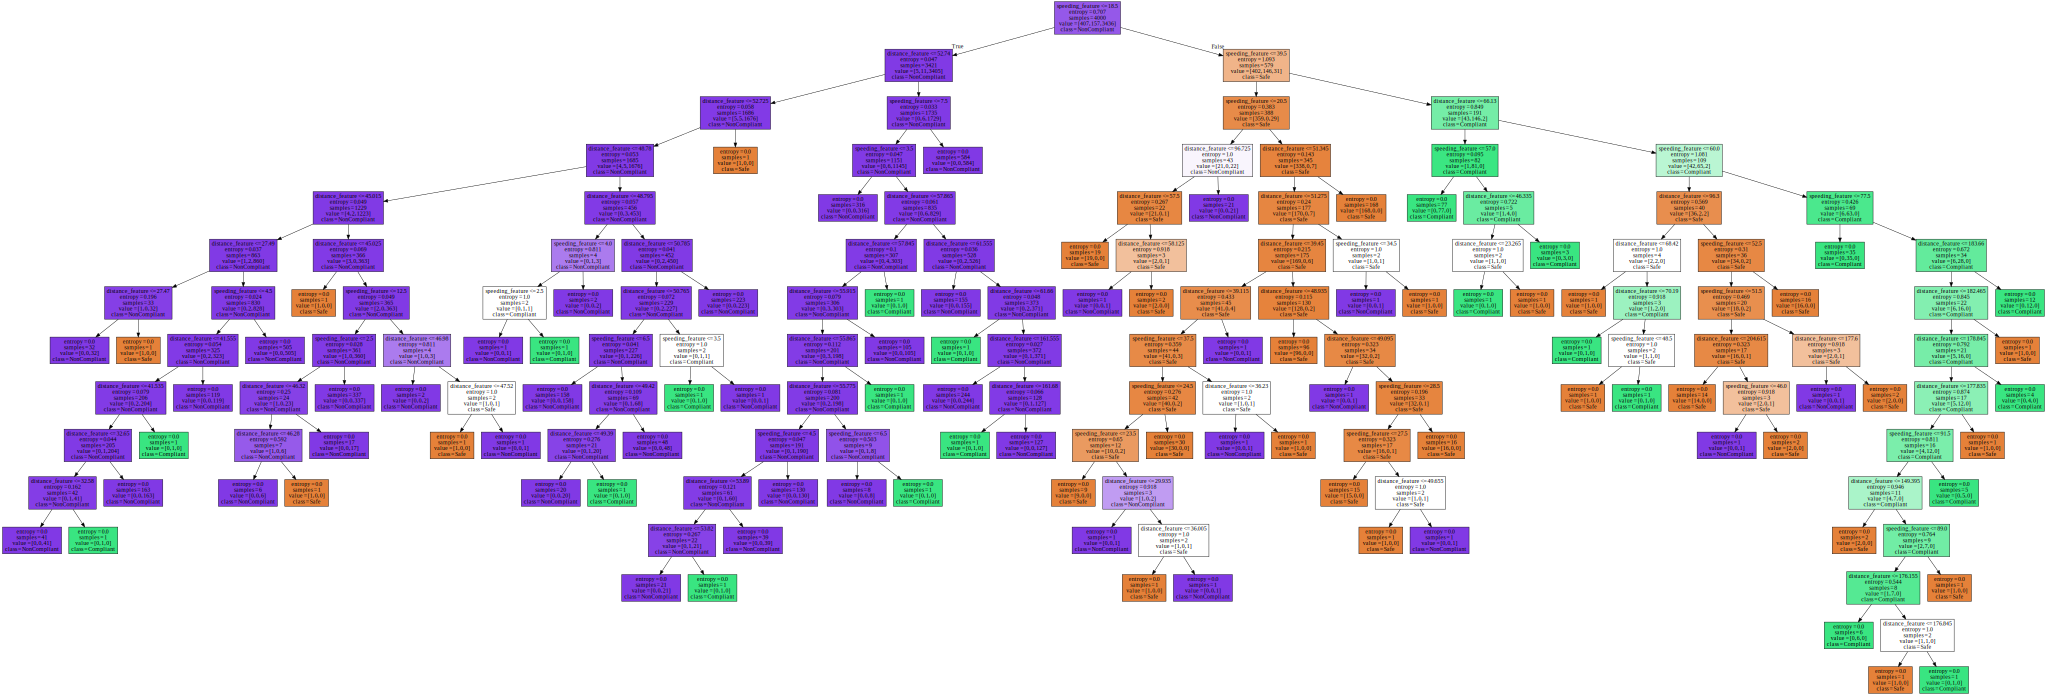

In [30]:
import graphviz 

dot_data = tree.export_graphviz(
    clf, out_file=None,
    feature_names=X.columns,
    class_names=Y.unique(),
    filled=True)

graph = graphviz.Source(dot_data)
graph.render(filename='tree')
graph